# 1/ Bollinger Bands Strategy

The first part of this notebook is to calculate Bollinger Bands and create signals (sell at the up cross and buy at the down cross)

In [1]:
import warnings
warnings.simplefilter("ignore")
import sys, time
from ultilities import timestr
from indicators import OBVol, MACD, Williams, StochOsc, RSIfunc, Bbands, average_true_range
from tradingpy import Backtester, Signal, SIDE
PY3 = sys.version_info[0] == 3
PY2 = sys.version_info[0] == 2
if PY3: _pip = 'pip3'
else: _pip = 'pip'
    
import numpy as np
import pandas as pd
try:
    import matplotlib.pyplot as plt
except:
    print('\tmatplotlib is missing. Please install by: \" {} install matplotlib \" '.format(_pip))
    
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({"hist.bins": 200})

In [2]:
# Read candles and ticks data from filepath
filepath = 'data/klines/'
symbol = 'BCHUSDT'
kl_size = '1m'
min_in_candle = 1
period = 6*60
data = pd.read_csv(filepath + "-%s-%s.csv" % (symbol, kl_size), index_col=0).iloc[:period]

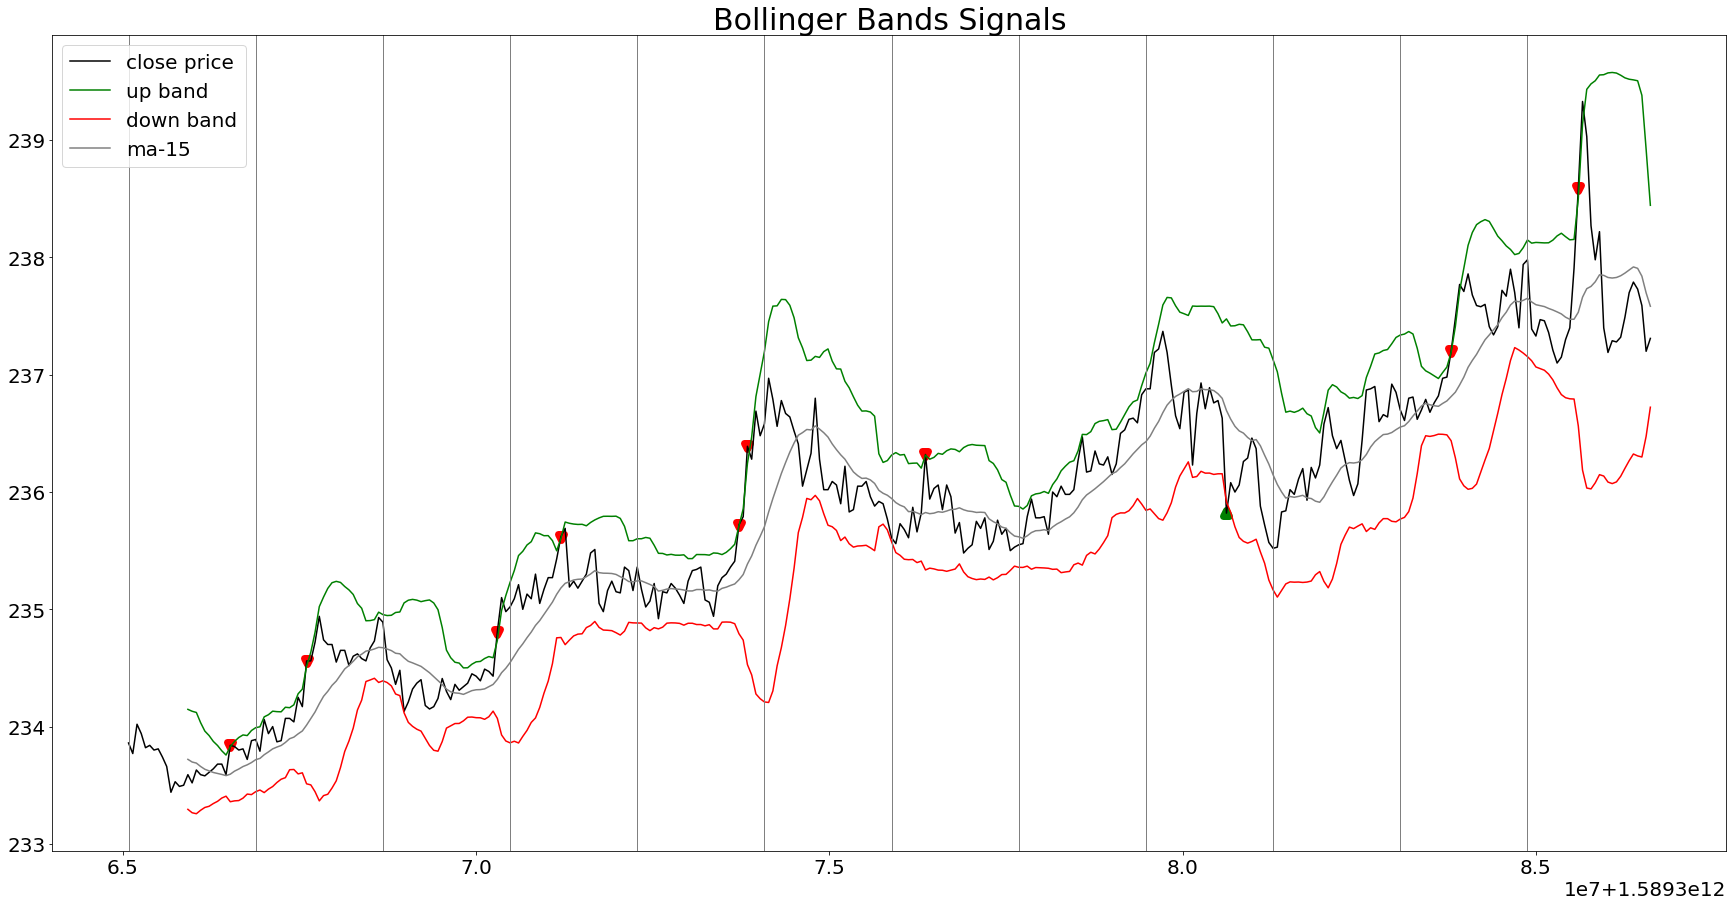

In [3]:
# Calculate bollinger bands, plot the results
wd, sd = 15, 2.5
ave, bb_up, bb_down = Bbands(data['_c'], window=wd, numsd=sd)
# up cross
crit1 = data['_c'].shift(1) < bb_up.shift(1)
crit2 = data['_c'] > bb_up
up_cross = data[crit1 & crit2]
# down cross
crit1 = data['_c'].shift(1) > bb_down.shift(1)
crit2 = data['_c'] < bb_down
dn_cross = data[crit1 & crit2]

data['side'] = np.zeros(data.shape[0])
data.loc[up_cross.index, 'side'] = -1.
data.loc[dn_cross.index, 'side'] = 1.

# Plot Bollinger Bands Signals
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.set_title('Bollinger Bands Signals', fontsize=30)
ax.plot(data['_t'], data['_c'], label='close price', color='black')
ax.plot(data['_t'], bb_up, label='up band', color='green')
ax.plot(data['_t'], bb_down, label='down band', color='red')
ax.plot(data['_t'], ave, label='ma-%d' % wd, color='grey')
ax.scatter(up_cross['_t'], up_cross['_c'], marker='v', color='r', linewidths=7)
ax.scatter(dn_cross['_t'], dn_cross['_c'], marker='^', color='g', linewidths=7)
for i in range(0, data.shape[0], 30):
    ax.axvline(x=data['_t'].iloc[i], linewidth=1, color='grey')
ax.legend(loc=2, prop={'size': 20})

In [4]:
data

,_t,_o,_h,_l,_c,_v,side
0,1589365080000,233.86,233.90,233.81,233.86,5.43161,0.0
1,1589365140000,233.80,233.86,233.71,233.77,27.11557,0.0
2,1589365200000,233.77,234.02,233.75,234.02,39.17011,0.0
3,1589365260000,234.00,234.02,233.86,233.94,22.60942,0.0
4,1589365320000,233.92,233.92,233.70,233.82,120.85630,0.0
...,...,...,...,...,...,...,...
355,1589386380000,237.70,237.86,237.61,237.79,73.87596,0.0
356,1589386440000,237.79,237.95,237.63,237.73,200.83475,0.0
357,1589386500000,237.76,237.82,237.45,237.59,147.09125,0.0
358,1589386560000,237.59,237.61,237.07,237.20,290.31073,0.0


# 2/ Backtesting the Bollinger Band signals

This part includes 3 steps:

    a) Generate Signals objects based on the predictions of RF classifier
    b) Generate Backtester object to calculate statistics of the trading session
    c) Plot Trades entry/exit and Equity Curve. Print out Session Summary

NOTE: Re-run the whole part to verify the codes fo problems 1, 2 and 4


a) Generate Signal objects

In [5]:
order_size = 100
model_signals = []
for i in range(data.shape[0]):
    atr, _ = average_true_range(data.iloc[:i].copy(), period=wd, alpha=0.3, highlow=False)
    side = data['side'].iloc[i]
    new_sig, startTime, price = None, data['_t'].iloc[i]+60*1000, data['_c'].iloc[i]
    expTime = startTime + 5*60*1000
    stopLoss = atr
    takeProfit = atr
    if side==1.0:
        new_sig = Signal(symbol=symbol, side='BUY', size=order_size, orderType='MARKET', positionSide='LONG', price=price, \
                         startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit)
    elif side==-1.0:
        new_sig = Signal(symbol=symbol, side='SELL', size=order_size, orderType='MARKET', positionSide='SHORT', price=price, \
                         startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit)

    if new_sig is not None:
        model_signals.append(new_sig)

In [6]:
model_signals

b) Update pricePath and check for exit_triggers()

In [7]:
# declare a Backtester object
tradeData = pd.DataFrame()
tradeData['_t'] = data['_t'] + min_in_candle*60*1000
tradeData['_p'] = data['_c']
backtest = Backtester(symbol=symbol, tradeData=tradeData, initBalance=200, orderSize=order_size, signalList=[])

# interation through all the BB signals
for sig in model_signals.copy():
    # check if there is an open position
    ready = False
    if len(backtest.signalList)==0: ready = True
    else:
        last_trade = backtest.signalList[-1]
        if sig.startTime > last_trade.clsTime: ready = True
            
    trades = tradeData[tradeData['_t']>=sig.startTime]
    # only enter trade when ready==True
    if ready and (trades.shape[0] > 0):
        print('\n----------------------')
        print( '\nPlace NEW order: \n' + str(sig) )
        sig.set_active(excTime=trades['_t'].iloc[0], excPrice=trades['_p'].iloc[0], excQty=sig.get_quantity())
        print( '\nSet BOOKED order ACTIVE: \n' + str(sig) )
        _exit = False
        while not _exit:
            for i in range(1, trades.shape[0]):
                _t, _p = trades['_t'].iloc[i], trades['_p'].iloc[i]
                sig.path_update(lastPrice=_p, lastTime=_t)
                if (sig.exit_triggers() is not None) or (_t==trades['_t'].iloc[-1]):
                    _exit = True
                    sig.set_cnt_ordered(cntorderId=0, cntTime=_t, cntType='MARKET')
                    print( '\nPlace COUNTER order: \n' + str(sig) )
                    sig.set_closed(clsTime=_t, clsPrice=_p)
                    print( '\nSet order CLOSED: \n' + str(sig) )
                    break
        backtest.add_signal(sig)
balance = backtest.balance_update()



----------------------

Place NEW order: 
Singal info: BCHUSDT Id:None  status:WAITING side:SELL type:MARKET quantity:0.43 price:233.84 time:20-05-13 10:43:00 exits:[0.664, 0.664, None]

Set BOOKED order ACTIVE: 
Singal info: BCHUSDT Id:None status:ACTIVE side:SELL type:MARKET quantity:0.43 price:233.84 time:20-05-13 10:43:00 exits:[0.664, 0.664, None]

Place COUNTER order: 
Singal info: BCHUSDT Id:0 status:CNT_ORDERED side:BUY type:MARKET quantity:0.43 type:MARKET time:20-05-13 11:01:00 exits:[0.664, 0.664, None]

Set order CLOSED: 
Singal info: BCHUSDT Id: 0 status:CLOSED side:BUY type:MARKET quantity:0.43 price:234.56 time:20-05-13 11:01:00 exits:[0.664, 0.664, None]

----------------------

Place NEW order: 
Singal info: BCHUSDT Id:None  status:WAITING side:SELL type:MARKET quantity:0.43 price:234.81 time:20-05-13 11:46:00 exits:[0.449, 0.449, None]

Set BOOKED order ACTIVE: 
Singal info: BCHUSDT Id:None status:ACTIVE side:SELL type:MARKET quantity:0.43 price:234.81 time:20-05-13 

c) Plot Trades entry/exit and Equity Curve


##########################     Backtester Summary     ##########################


	Symbol: BCHUSDT
	Trading Time: 	5.98 h

	Gross Profit: 	1.04580
	Gross Loss: 	1.04110
	Commision: 	0.51064
	Net Profit: 	-0.50594
	Total number of trades: 	8
	Number of win trades: 	4
	Number of loss trades: 	4
	Average time in position: 	7.12 mins


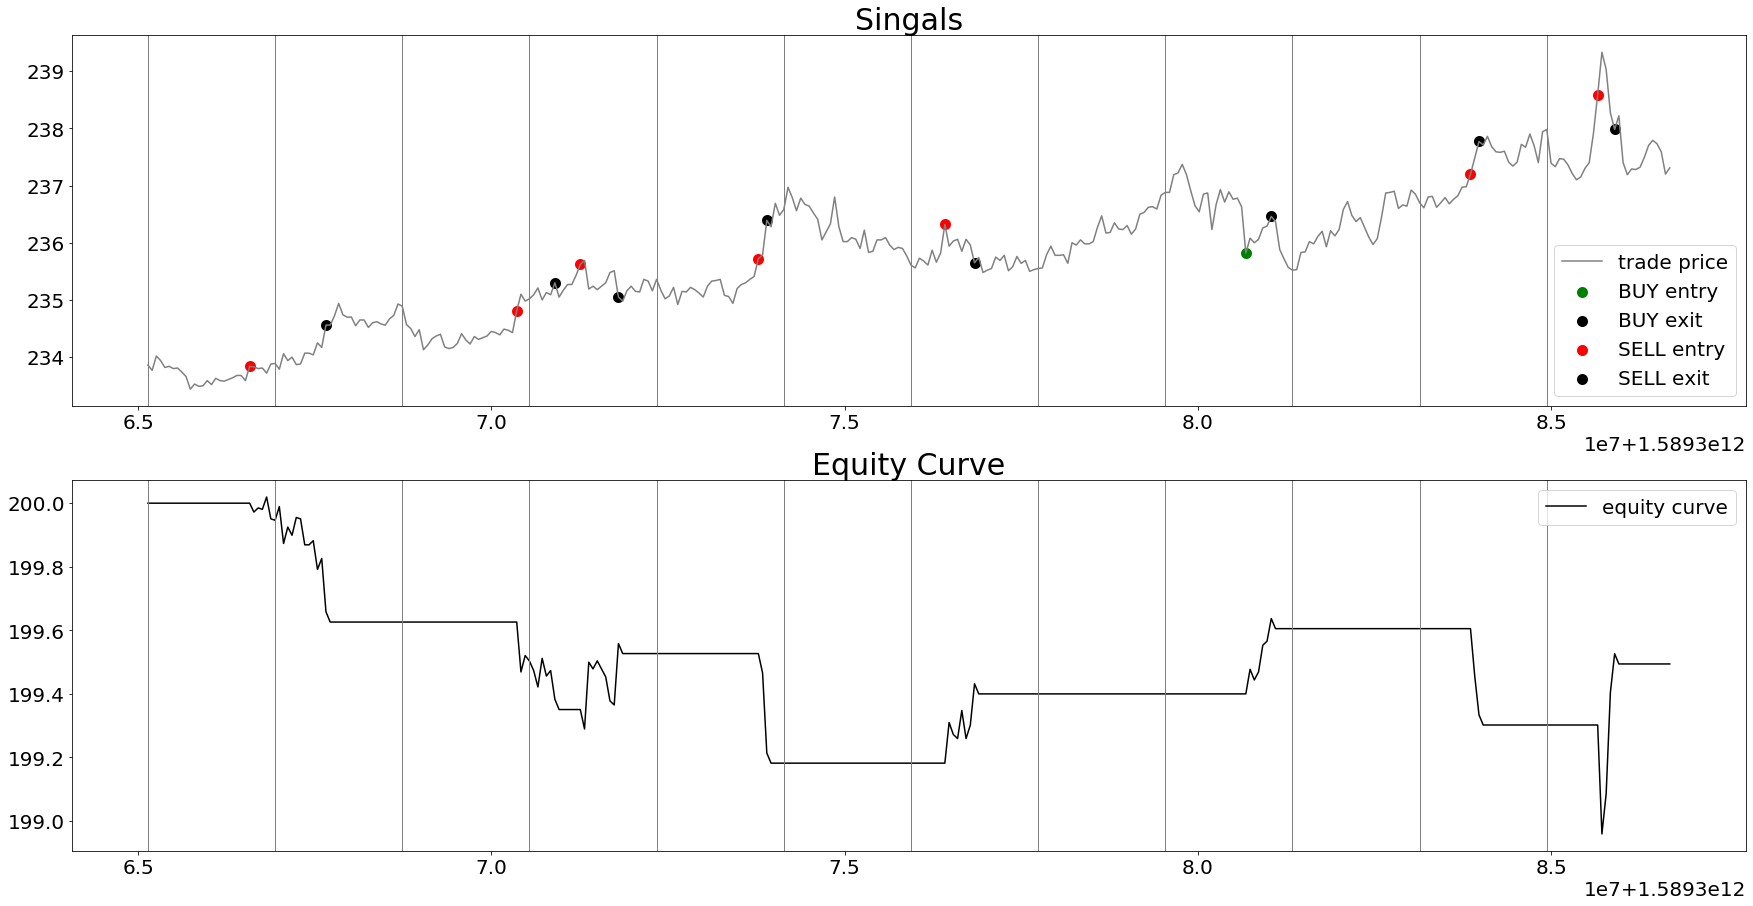

In [8]:
# Buy and Sell Trades from Backtester
buy = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
sell = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
for sig in backtest.signalList:
    if sig.side == 'BUY':
        buy = buy.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)
    else:
        sell = sell.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)

# Plot Trades entry/exit and Equity Curve
fig, axs = plt.subplots(2, figsize=(30, 15))
axs[0].set_title('Singals', fontsize=30)
axs[0].plot(tradeData['_t'], tradeData['_p'], label='trade price', color='grey')
axs[0].scatter(buy['excTime'], buy['excPrice'], label='BUY entry', color='green', linewidths=5)
axs[0].scatter(buy['clsTime'], buy['clsPrice'], label='BUY exit', color='black', linewidths=5)
axs[0].scatter(sell['excTime'], sell['excPrice'], label='SELL entry', color='red', linewidths=5)
axs[0].scatter(sell['clsTime'], sell['clsPrice'], label='SELL exit', color='black', linewidths=5)
for i in range(0, tradeData.shape[0], 30):
    axs[0].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[0].legend()

axs[1].set_title('Equity Curve', fontsize=30)
axs[1].plot(balance['_t'], balance['_b'], label='equity curve', color='black')
for i in range(0, tradeData.shape[0], 30):
    axs[1].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[1].legend()

backtest.summary()


# Sample solution for Problem 3, 4

Combine 2.a and 2.b into a single 'for loop' ('while loop' is left for exercise)

In [10]:
### PROBLEM 3 : INSERT this block to combine 2.a and 2.b ###
order_size = 100
tradeData = pd.DataFrame()
tradeData['_t'] = data['_t'] + min_in_candle*60*1000
tradeData['_p'] = data['_c']
backtest = Backtester(symbol=symbol, tradeData=tradeData, initBalance=200, orderSize=order_size, signalList=[])

for i in range(data.shape[0]):
    startTime = tradeData['_t'].iloc[i]
    # check if there is an open position
    ready = False
    if len(backtest.signalList)==0: ready = True
    else:
        last_trade = backtest.signalList[-1]
        if startTime > last_trade.clsTime: ready = True

    trades = tradeData[tradeData['_t']>=startTime]
    if ready and (trades.shape[0] > 0):
        atr, _ = average_true_range(data.iloc[:i].copy(), period=wd, alpha=0.3, highlow=False)
        sig, side, price = None, data['side'].iloc[i], tradeData['_p'].iloc[i]
        expTime = startTime + 5*60*1000
        stopLoss = atr
        takeProfit = atr
        if side==1.0:
            sig = Signal(symbol=symbol, side='BUY', size=order_size, orderType='MARKET', positionSide='LONG', price=price, \
                             startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit)
        elif side==-1.0:
            sig = Signal(symbol=symbol, side='SELL', size=order_size, orderType='MARKET', positionSide='SHORT', price=price, \
                             startTime=startTime, expTime=expTime, stopLoss=stopLoss, takeProfit=takeProfit)
        if sig is not None:
            print('\n----------------------')
            print( '\nFound a Signal: \n' + str(sig) )
            print( '\nPlace NEW order: \n' + str(sig) )
            sig.set_active(excTime=trades['_t'].iloc[0], excPrice=trades['_p'].iloc[0], excQty=sig.get_quantity())
            print( '\nSet BOOKED order ACTIVE: \n' + str(sig) )
            _exit = False
            while not _exit:
                for j in range(1, trades.shape[0]):
                    _t, _p = trades['_t'].iloc[j], trades['_p'].iloc[j]
                    sig.path_update(lastPrice=_p, lastTime=_t)
                    if sig.exit_triggers(retrace=True) is not None or _t==trades['_t'].iloc[-1]:
                        _exit = True
                        sig.set_cnt_ordered(cntorderId=0, cntTime=_t, cntType='MARKET')
                        print( '\nPlace COUNTER order: \n' + str(sig) )
                        sig.set_closed(clsTime=_t, clsPrice=_p)
                        print( '\nSet order CLOSED: \n' + str(sig) )
                        break
            backtest.add_signal(sig)
balance = backtest.balance_update()


----------------------

Found a Signal: 
Singal info: BCHUSDT Id:None  status:WAITING side:SELL type:MARKET quantity:0.43 price:233.84 time:20-05-13 10:43:00 exits:[0.664, 0.664, None]

Place NEW order: 
Singal info: BCHUSDT Id:None  status:WAITING side:SELL type:MARKET quantity:0.43 price:233.84 time:20-05-13 10:43:00 exits:[0.664, 0.664, None]

Set BOOKED order ACTIVE: 
Singal info: BCHUSDT Id:None status:ACTIVE side:SELL type:MARKET quantity:0.43 price:233.84 time:20-05-13 10:43:00 exits:[0.664, 0.664, None]

Place COUNTER order: 
Singal info: BCHUSDT Id:0 status:CNT_ORDERED side:BUY type:MARKET quantity:0.43 type:MARKET time:20-05-13 11:24:00 exits:[0.664, 0.664, None]

Set order CLOSED: 
Singal info: BCHUSDT Id: 0 status:CLOSED side:BUY type:MARKET quantity:0.43 price:234.13 time:20-05-13 11:24:00 exits:[0.664, 0.664, None]

----------------------

Found a Signal: 
Singal info: BCHUSDT Id:None  status:WAITING side:SELL type:MARKET quantity:0.43 price:234.81 time:20-05-13 11:46:00

Plot Trades entry/exit and Equity Curve


##########################     Backtester Summary     ##########################


	Symbol: BCHUSDT
	Trading Time: 	5.98 h

	Gross Profit: 	0.68460
	Gross Loss: 	0.36160
	Commision: 	0.44721
	Net Profit: 	-0.12421
	Total number of trades: 	7
	Number of win trades: 	3
	Number of loss trades: 	4
	Average time in position: 	16.43 mins


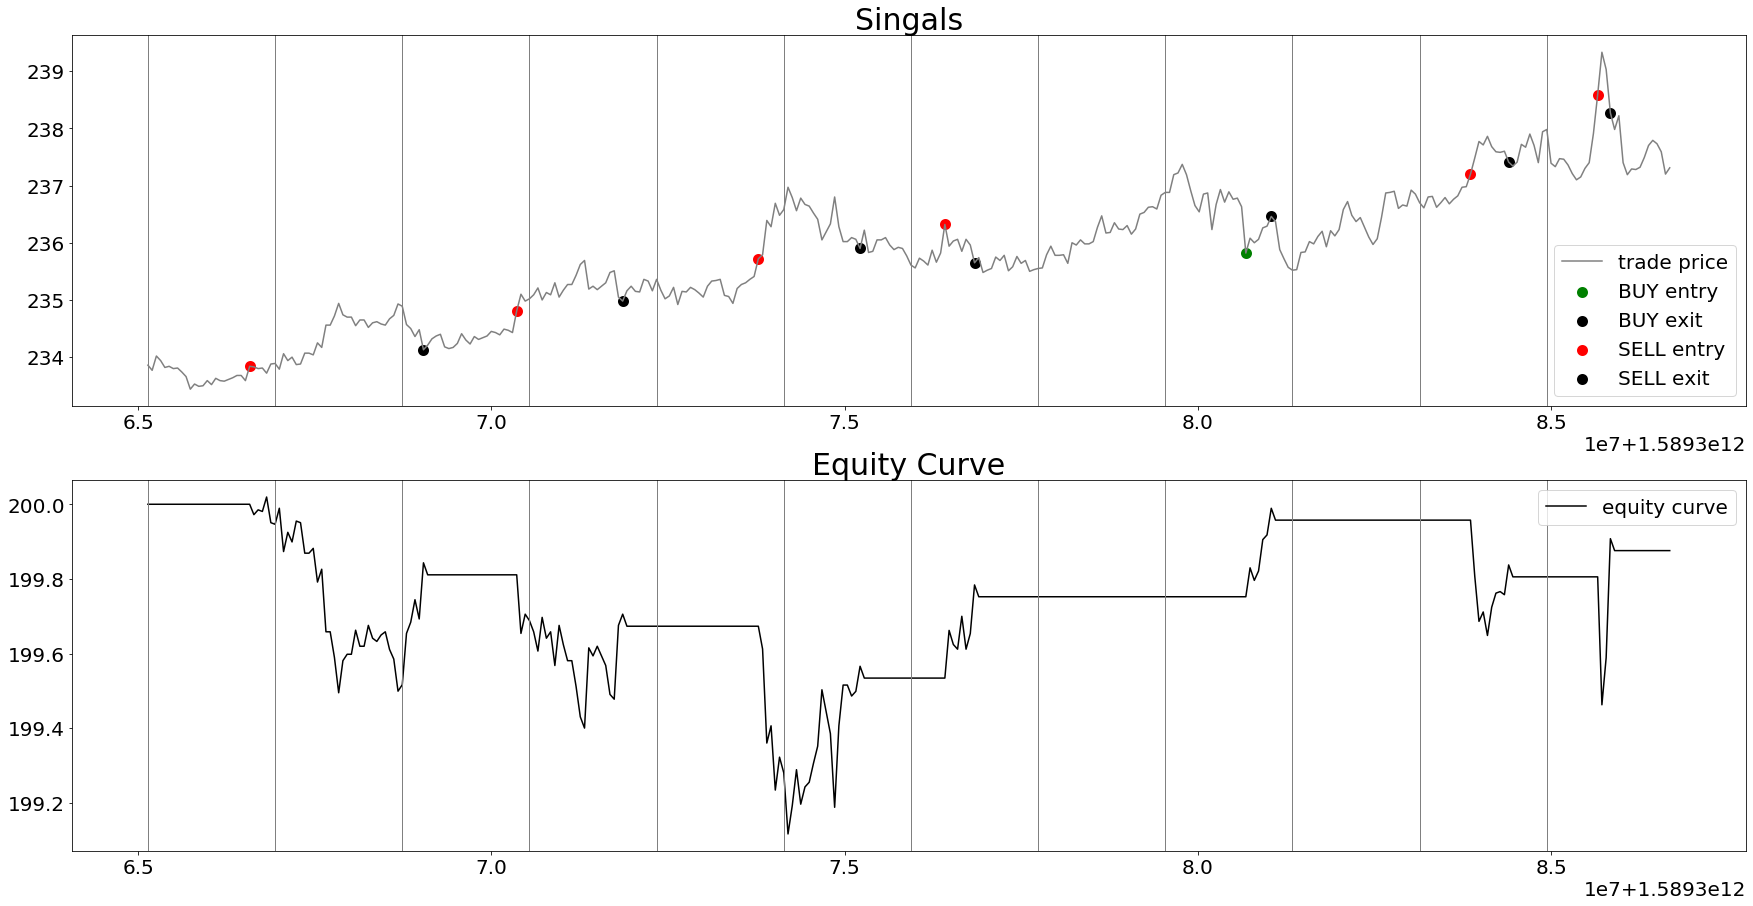

In [11]:
# Buy and Sell Trades from Backtester
buy = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
sell = pd.DataFrame(columns=['excTime', 'excPrice', 'clsTime', 'clsPrice'])
for sig in backtest.signalList:
    if sig.side == 'BUY':
        buy = buy.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)
    else:
        sell = sell.append({'excTime': sig.excTime, 'excPrice': sig.excPrice, 'clsTime': sig.clsTime, 'clsPrice': sig.clsPrice}, ignore_index=True)

# Plot Trades entry/exit and Equity Curve
fig, axs = plt.subplots(2, figsize=(30, 15))
axs[0].set_title('Singals', fontsize=30)
axs[0].plot(tradeData['_t'], tradeData['_p'], label='trade price', color='grey')
axs[0].scatter(buy['excTime'], buy['excPrice'], label='BUY entry', color='green', linewidths=5)
axs[0].scatter(buy['clsTime'], buy['clsPrice'], label='BUY exit', color='black', linewidths=5)
axs[0].scatter(sell['excTime'], sell['excPrice'], label='SELL entry', color='red', linewidths=5)
axs[0].scatter(sell['clsTime'], sell['clsPrice'], label='SELL exit', color='black', linewidths=5)
for i in range(0, tradeData.shape[0], 30):
    axs[0].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[0].legend()

axs[1].set_title('Equity Curve', fontsize=30)
axs[1].plot(balance['_t'], balance['_b'], label='equity curve', color='black')
for i in range(0, tradeData.shape[0], 30):
    axs[1].axvline(x=tradeData['_t'].iloc[i], linewidth=1, color='grey')
axs[1].legend()

backtest.summary()